In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
sns_colors = sns.color_palette('colorblind')
import matplotlib.pyplot as plt
# Importing dataset 
df =pd.read_csv('/content/dataset.csv')

In [2]:
df.head()


,index,having_IPhaving_IP_Address,URLURL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,port,HTTPS_token,Request_URL,URL_of_Anchor,Links_in_tags,SFH,Submitting_to_email,Abnormal_URL,Redirect,on_mouseover,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,1,-1,1,1,1,-1,-1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,-1,0,1,1,1,1,-1,-1,-1,-1,1,1,-1,-1
1,2,1,1,1,1,1,-1,0,1,-1,1,1,-1,1,0,-1,-1,1,1,0,1,1,1,1,-1,-1,0,-1,1,1,1,-1
2,3,1,0,1,1,1,-1,-1,-1,-1,1,1,-1,1,0,-1,-1,-1,-1,0,1,1,1,1,1,-1,1,-1,1,0,-1,-1
3,4,1,0,1,1,1,-1,-1,-1,1,1,1,-1,-1,0,0,-1,1,1,0,1,1,1,1,-1,-1,1,-1,1,-1,1,-1
4,5,1,0,-1,1,1,-1,1,1,-1,1,1,1,1,0,0,-1,1,1,0,-1,1,-1,1,-1,-1,0,-1,1,1,1,1


In [3]:
df.drop(['index'], axis = 1, inplace = True) 
#df.set_index('having_IPhaving_IP_Address', inplace=True)

df.head()

,having_IPhaving_IP_Address,URLURL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,port,HTTPS_token,Request_URL,URL_of_Anchor,Links_in_tags,SFH,Submitting_to_email,Abnormal_URL,Redirect,on_mouseover,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,-1,0,1,1,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,1,-1,1,0,-1,-1,1,1,0,1,1,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,1,-1,1,0,-1,-1,-1,-1,0,1,1,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,1,-1,-1,0,0,-1,1,1,0,1,1,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,1,1,1,0,0,-1,1,1,0,-1,1,-1,1,-1,-1,0,-1,1,1,1,1


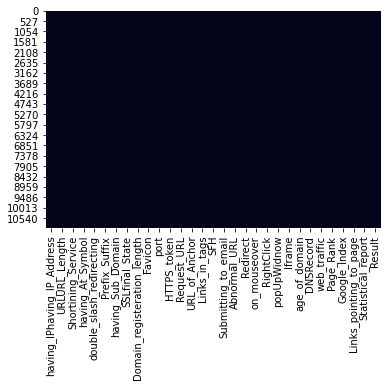

In [4]:
sns.heatmap(df.isnull(), cbar=False) # For count missing values

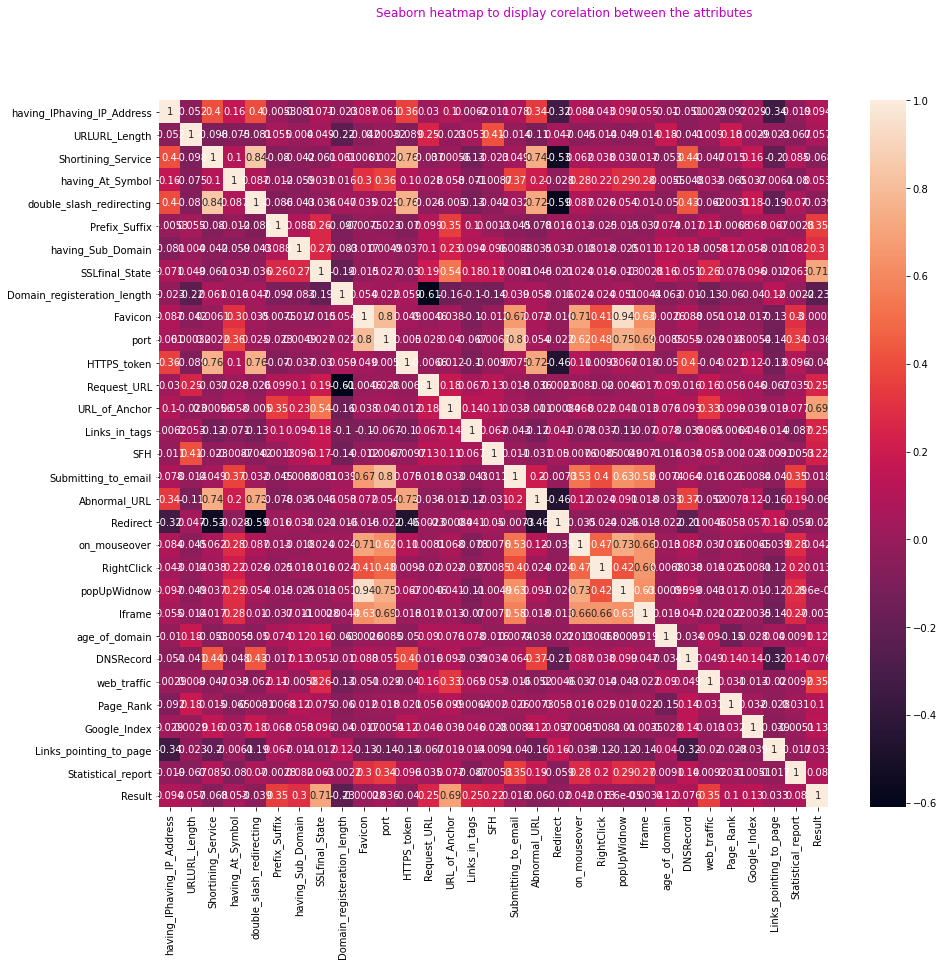

In [6]:
#Correlation heatmap

plt.figure(figsize=(15,13))
plt.suptitle("Seaborn heatmap to display corelation between the attributes", color='m')
sns.heatmap(df.corr(),annot=True)
plt.show()

In [7]:
#Unique values for each columns
col=df.columns
for i in col:
     if  i!='index':
        print(i,df[i].unique())

having_IPhaving_IP_Address [-1  1]
URLURL_Length [ 1  0 -1]
Shortining_Service [ 1 -1]
having_At_Symbol [ 1 -1]
double_slash_redirecting [-1  1]
Prefix_Suffix [-1  1]
having_Sub_Domain [-1  0  1]
SSLfinal_State [-1  1  0]
Domain_registeration_length [-1  1]
Favicon [ 1 -1]
port [ 1 -1]
HTTPS_token [-1  1]
Request_URL [ 1 -1]
URL_of_Anchor [-1  0  1]
Links_in_tags [ 1 -1  0]
SFH [-1  1  0]
Submitting_to_email [-1  1]
Abnormal_URL [-1  1]
Redirect [0 1]
on_mouseover [ 1 -1]
RightClick [ 1 -1]
popUpWidnow [ 1 -1]
Iframe [ 1 -1]
age_of_domain [-1  1]
DNSRecord [-1  1]
web_traffic [-1  0  1]
Page_Rank [-1  1]
Google_Index [ 1 -1]
Links_pointing_to_page [ 1  0 -1]
Statistical_report [-1  1]
Result [-1  1]


In [8]:
import tensorflow as tf
tf.random.set_seed(123)



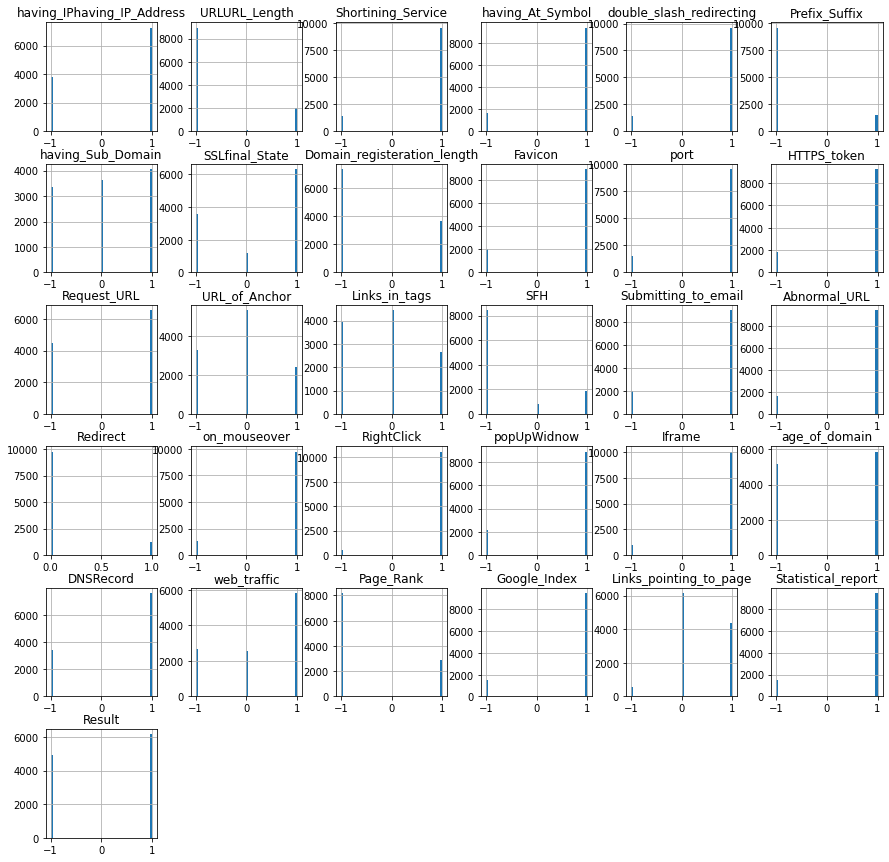

In [9]:

#Plotting the data distribution
df.hist(bins = 50,figsize = (15,15))
plt.show()

In [10]:

df.describe()

,having_IPhaving_IP_Address,URLURL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,port,HTTPS_token,Request_URL,URL_of_Anchor,Links_in_tags,SFH,Submitting_to_email,Abnormal_URL,Redirect,on_mouseover,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
count,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000
mean,0.313795,-0.633198,0.738761,0.700588,0.741474,-0.734962,0.063953,0.250927,-0.336771,0.628584,0.728268,0.675079,0.186793,-0.076526,-0.118137,-0.595749,0.635640,0.705292,0.115694,0.762099,0.913885,0.613388,0.816915,0.061239,0.377114,0.287291,-0.483673,0.721574,0.344007,0.719584,0.113885
std,0.949534,0.766095,0.673998,0.713598,0.671011,0.678139,0.817518,0.911892,0.941629,0.777777,0.685324,0.737779,0.982444,0.715138,0.763973,0.759143,0.772021,0.708949,0.319872,0.647490,0.405991,0.789818,0.576784,0.998168,0.926209,0.827733,0.875289,0.692369,0.569944,0.694437,0.993539
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,0.000000,-1.000000,1.000000,0.000000,1.000000,-1.000000
50%,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,-1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,0.000000,1.000000,1.000000
75%,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,-1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


To even out the distribution while splitting the data into training & testing sets, we need to shuffle it. This even evades the case of overfitting while model training.

In [12]:
# shuffling the rows in the dataset so that when splitting the train and test set are equally distributed
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,having_IPhaving_IP_Address,URLURL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,port,HTTPS_token,Request_URL,URL_of_Anchor,Links_in_tags,SFH,Submitting_to_email,Abnormal_URL,Redirect,on_mouseover,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,1,1,1,1,1,-1,0,0,-1,-1,-1,1,1,-1,1,1,-1,1,0,-1,1,-1,-1,1,1,-1,-1,1,0,-1,-1
1,1,0,-1,1,1,-1,-1,1,-1,1,1,1,1,0,1,-1,-1,-1,0,1,1,1,1,1,-1,1,-1,-1,0,-1,1
2,1,-1,1,1,1,-1,0,1,1,1,1,1,-1,0,1,-1,-1,1,0,1,1,1,1,-1,-1,-1,-1,1,1,1,1
3,1,-1,1,1,1,1,0,1,1,-1,-1,1,-1,1,0,-1,-1,1,0,1,1,-1,-1,-1,1,-1,-1,1,0,1,1
4,1,-1,1,1,1,-1,0,0,-1,-1,1,1,1,-1,1,-1,1,1,0,1,1,-1,1,1,-1,1,-1,1,1,1,-1


In [13]:
df['Result']=df['Result'].replace(-1,0)

In [14]:

# Separating & assigning features and target columns to X & y
y = df['Result']
X = df.drop('Result',axis=1)
X.shape, y.shape

((11055, 30), (11055,))

In [15]:
#importing packages
from sklearn.metrics import accuracy_score

In [16]:
# Creating holders to store the model performance results
ML_Model = []
acc_train = []
acc_test = []

#function to call for storing the results
def storeResults(model, a,b):
  ML_Model.append(model)
  acc_train.append(round(a, 3))
  acc_test.append(round(b, 3))

In [17]:
# Splitting the dataset into train and test sets: 80-20 split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, random_state = 12)
X_train.shape, X_test.shape

((8844, 30), (2211, 30))

Tensorflow Boosted Estimators

In [18]:
CATEGORICAL_COLUMNS = ['having_IPhaving_IP_Address','URLURL_Length','Shortining_Service','having_At_Symbol','double_slash_redirecting',
 'Prefix_Suffix','having_Sub_Domain','SSLfinal_State','Domain_registeration_length',
 'Favicon','port','HTTPS_token','Request_URL','URL_of_Anchor','Links_in_tags','Submitting_to_email','SFH','Abnormal_URL','Redirect',
 'on_mouseover','RightClick','popUpWidnow','Iframe','age_of_domain','DNSRecord','web_traffic','Page_Rank','Google_Index',
 'Links_pointing_to_page','Statistical_report']


def one_hot_cat_column(feature_name, vocab):
  return tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = X_train[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))



In [19]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = dataset.repeat(n_epochs)
    # In memory training doesn't use batching.
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(X_train, y_train)
eval_input_fn = make_input_fn(X_test, y_test, shuffle=False, n_epochs=1)


In [20]:
from IPython.display import clear_output
linear_est = tf.estimator.LinearClassifier(feature_columns)

# Train model.
linear_est.train(train_input_fn, max_steps=100)

# Evaluation.
result = linear_est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.911352
accuracy_baseline         0.564451
auc                       0.977649
auc_precision_recall      0.982729
average_loss              0.233073
label/mean                0.564451
loss                      0.233073
precision                 0.903374
prediction/mean           0.576218
recall                    0.943910
global_step             100.000000
dtype: float64


In [21]:
# Since data fits into memory, use entire dataset per layer. It will be faster.
# Above one batch is defined as the entire dataset.
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches)

# The model will stop training once the specified number of trees is built, not
# based on the number of steps.
est.train(train_input_fn, max_steps=100)

# Eval.
result = est.evaluate(eval_input_fn)
clear_output()
res = pd.Series(result)
print(res[0])
print(pd.Series(result))

0.9511533379554749
accuracy                  0.951153
accuracy_baseline         0.564451
auc                       0.992885
auc_precision_recall      0.994548
average_loss              0.113692
label/mean                0.564451
loss                      0.113692
precision                 0.952381
prediction/mean           0.567964
recall                    0.961538
global_step             100.000000
dtype: float64


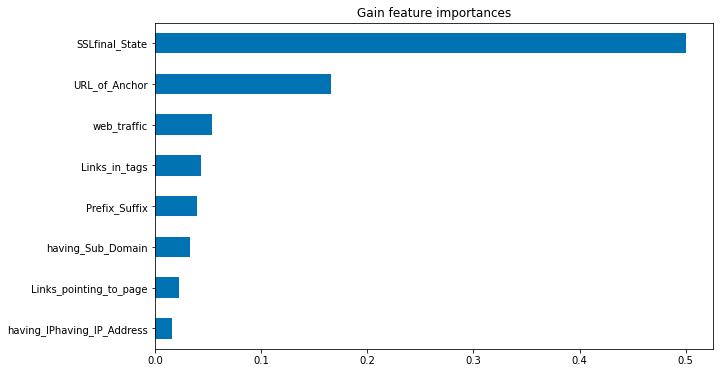

In [22]:
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# Visualize importances.
N = 8
ax = (df_imp.iloc[0:N][::-1]
    .plot(kind='barh',
          color=sns_colors[0],
          title='Gain feature importances',
          figsize=(10, 6)))
ax.grid(False, axis='y')

Random Forest Classfier

In [23]:
# Random Forest model
from sklearn.ensemble import RandomForestClassifier

# instantiate the model
forest = RandomForestClassifier(max_depth=5)

# fit the model 
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [24]:
#predicting the target value from the model for the samples
y_test_forest = forest.predict(X_test)
y_train_forest = forest.predict(X_train)

In [25]:
#computing the accuracy of the model performance
acc_train_forest = accuracy_score(y_train,y_train_forest)
acc_test_forest = accuracy_score(y_test,y_test_forest)

print("Random forest: Accuracy on training Data: {:.3f}".format(acc_train_forest))
print("Random forest: Accuracy on test Data: {:.3f}".format(acc_test_forest))

Random forest: Accuracy on training Data: 0.934
Random forest: Accuracy on test Data: 0.930


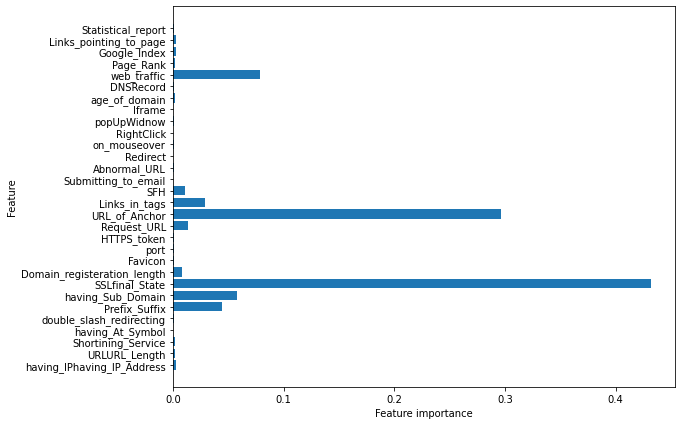

In [26]:

#checking the feature improtance in the model
plt.figure(figsize=(9,7))
n_features = X_train.shape[1]
plt.barh(range(n_features), forest.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_train.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()

In [27]:
#storing the results. The below mentioned order of parameter passing is important.
#Caution: Execute only once to avoid duplications.
storeResults('Random Forest', acc_train_forest, acc_test_forest)

Multi-Layer Perceptron

In [28]:
# Multilayer Perceptrons model
from sklearn.neural_network import MLPClassifier

# instantiate the model
mlp = MLPClassifier(alpha=0.001, hidden_layer_sizes=([100,100,100]))

# fit the model 
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=[100, 100, 100], learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [31]:
#predicting the target value from the model for the samples
y_test_mlp = mlp.predict(X_test)
y_train_mlp = mlp.predict(X_train)

In [33]:

#computing the accuracy of the model performance
acc_train_mlp = accuracy_score(y_train,y_train_mlp)
acc_test_mlp = accuracy_score(y_test,y_test_mlp)

print("Multilayer Perceptrons: Accuracy on training Data: {:.3f}".format(acc_train_mlp))

print("Multilayer Perceptrons: Accuracy on test Data: {:.3f}".format(acc_test_mlp))

Multilayer Perceptrons: Accuracy on training Data: 0.988
Multilayer Perceptrons: Accuracy on test Data: 0.972


In [34]:
#storing the results. The below mentioned order of parameter passing is important.
#Caution: Execute only once to avoid duplications.
storeResults('Multilayer Perceptrons', acc_train_mlp, acc_test_mlp)

Auto Encoders

In [35]:
#importing required packages
import keras
from keras.layers import Input, Dense
from keras import regularizers
import tensorflow as tf
from keras.models import Model
from sklearn import metrics

In [38]:
#building autoencoder model

input_dim = X_train.shape[1]
encoding_dim = input_dim

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu",
                activity_regularizer=regularizers.l1(10e-4))(input_layer)
encoder = Dense(int(encoding_dim), activation="relu")(encoder)

encoder = Dense(int(encoding_dim-2), activation="relu")(encoder)
code = Dense(int(encoding_dim-4), activation='relu')(encoder)
decoder = Dense(int(encoding_dim-2), activation='relu')(code)

decoder = Dense(int(encoding_dim), activation='relu')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense_7 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_8 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_9 (Dense)              (None, 28)                868       
_________________________________________________________________
dense_12 (Dense)             (None, 30)                870       
_________________________________________________________________
dense_13 (Dense)             (None, 30)                930       
Total params: 4,528
Trainable params: 4,528
Non-trainable params: 0
_________________________________________________________

In [39]:
#compiling the model
autoencoder.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

#Training the model
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=64, shuffle=True, validation_split=0.2)

Epoch 1/50
111/111 [==============================] - 1s 4ms/step - loss: 1.1552 - accuracy: 0.0902 - val_loss: -0.7635 - val_accuracy: 0.0424
Epoch 2/50
111/111 [==============================] - 0s 2ms/step - loss: -0.7161 - accuracy: 0.0783 - val_loss: -0.7977 - val_accuracy: 0.1261
Epoch 3/50
111/111 [==============================] - 0s 2ms/step - loss: -0.8744 - accuracy: 0.0784 - val_loss: -1.0802 - val_accuracy: 0.0441
Epoch 4/50
111/111 [==============================] - 0s 2ms/step - loss: -1.0576 - accuracy: 0.0475 - val_loss: -0.8613 - val_accuracy: 0.0034
Epoch 5/50
111/111 [==============================] - 0s 2ms/step - loss: -1.0129 - accuracy: 0.0411 - val_loss: -1.2282 - val_accuracy: 0.1289
Epoch 6/50
111/111 [==============================] - 0s 2ms/step - loss: -1.2020 - accuracy: 0.1265 - val_loss: -1.3150 - val_accuracy: 0.0763
Epoch 7/50
111/111 [==============================] - 0s 2ms/step - loss: -1.2948 - accuracy: 0.0792 - val_loss: -1.3800 - val_accuracy: 

In [40]:
#perfotmance Evaluation
acc_train_auto = autoencoder.evaluate(X_train, X_train)[1]
acc_test_auto = autoencoder.evaluate(X_test, X_test)[1]

print('\nAutoencoder: Accuracy on training Data: {:.3f}' .format(acc_train_auto))
print('Autoencoder: Accuracy on test Data: {:.3f}' .format(acc_test_auto))

70/70 [==============================] - 0s 1ms/step - loss: -1.6467 - accuracy: 0.0294

Autoencoder: Accuracy on training Data: 0.038
Autoencoder: Accuracy on test Data: 0.029


In [41]:

#storing the results. The below mentioned order of parameter passing is important.
#Caution: Execute only once to avoid duplications.
storeResults('AutoEncoder', acc_train_auto, acc_test_auto)

XG Boost Classifier

In [42]:
#XGBoost Classification model
from xgboost import XGBClassifier

# instantiate the model
xgb = XGBClassifier(learning_rate=0.4,max_depth=7)
#fit the model
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.4, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [43]:
#predicting the target value from the model for the samples
y_test_xgb = xgb.predict(X_test)
y_train_xgb = xgb.predict(X_train)

In [44]:

#computing the accuracy of the model performance
acc_train_xgb = accuracy_score(y_train,y_train_xgb)
acc_test_xgb = accuracy_score(y_test,y_test_xgb)

print("XGBoost: Accuracy on training Data: {:.3f}".format(acc_train_xgb))
print("XGBoost : Accuracy on test Data: {:.3f}".format(acc_test_xgb))

XGBoost: Accuracy on training Data: 0.988
XGBoost : Accuracy on test Data: 0.980


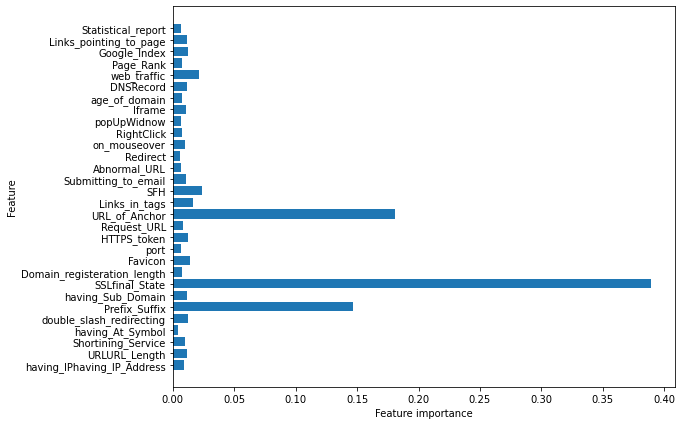

In [45]:
#checking the feature improtance in the model
plt.figure(figsize=(9,7))
n_features = X_train.shape[1]
plt.barh(range(n_features), xgb.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_train.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()

In [46]:
#storing the results. The below mentioned order of parameter passing is important.
#Caution: Execute only once to avoid duplications.
storeResults('XGBoost', acc_train_xgb, acc_test_xgb)

In [47]:
#creating dataframe
results = pd.DataFrame({ 'ML Model': ML_Model,    
    'Train Accuracy': acc_train,
    'Test Accuracy': acc_test})
results

,ML Model,Train Accuracy,Test Accuracy
0,Random Forest,0.934,0.930
1,Multilayer Perceptrons,0.988,0.972
2,AutoEncoder,0.038,0.029
3,XGBoost,0.988,0.980


In [48]:

#Sorting the datafram on accuracy
results.sort_values(by=['Test Accuracy', 'Train Accuracy'], ascending=False)

,ML Model,Train Accuracy,Test Accuracy
3,XGBoost,0.988,0.980
1,Multilayer Perceptrons,0.988,0.972
0,Random Forest,0.934,0.930
2,AutoEncoder,0.038,0.029
